In [5]:
pip install pandas matplotlib seaborn numpy scipy statsmodels scikit-learn xgboost pydantic fastapi uvicorn


   -------------------- ------------------- 1/2 [uvicorn]
   ---------------------------------------- 2/2 [uvicorn]

Note: you may need to restart the kernel to use updated packages.


In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from scipy.stats import randint, uniform
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import joblib

In [2]:
# Model Development Life Cycle 1 - Understanding the intent
# We have a dataset of certain people who have heart poin and might be facing heart disease. 
# Upon diagnosing, a few of them actually had heart disease and important vitals were captured. 
# We need to understand how the vitals help us in classifying if a patient has a heart disease.
# Attributes are below:

#1  |   age       |  age of the patient                                                                                  | quantitative
#2  |   sex       |  gender of the patient                                                                               | qualitative
#3  |   cp        |  type of chest pain (1:'Typical Angina', 2:'atypical angina', 3:'non-anginal pain', 4:'asymptomatic')| qualitative           
#4  |   trestbps  |  resting blood pressure (in mm Hg on admission to the hospital)                                      | quantitative    
#5  |   chol      |  serum  cholesterol in mg/dl                                                                         | quantitative     
#6  |   fbs       |  (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)                                             | qualitative
#7  |   restecg   |  resting ECG results (0: 'normal', 1 and 2: 'abnormal')                                              | qualitative
#8  |   thalach   |  maximum heart rate achieved                                                                         | quantitative
#9  |   exang     |  exercise induced angina (1 = yes; 0 = no)                                                           | qualitative
#10 |   oldpeak   |  ST depression induced by exercise relative to rest                                                  | quantitative
#11 |   slope     |  the slope of the peak exercise ST segment (1: 'upsloping', 2: 'flat', 3: 'down sloping')            | qualitative 
#12 |   ca        |  number of major vessels (0-3) colored by fluoroscopy                                                | qualitative   
#13 |   thal      |  thalassemia (3: 'normal', 6: 'fixed defect' , 7: 'reversible defect')                               | qualitative    
#14 |   num       |  angiographic disease status (0: no heart disease, > 0: heart disease)                               | qualitative

In [3]:
# data
columns = ['age',
           'sex',
           'cp',
           'trestbps',
           'chol',
           'fbs',
           'restecg',
           'thalach',
           'exang',
           'oldpeak',
           'slope',
           'ca',
           'thal',
           'num']
df = pd.read_csv('processed_cleveland.csv', header=None, names=columns)
conditions = [
    (df['num'] >= 1)
]
choices = [1]
df['has_heart_disease']=np.select(conditions, choices, default=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                303 non-null    int64  
 1   sex                303 non-null    int64  
 2   cp                 303 non-null    int64  
 3   trestbps           303 non-null    int64  
 4   chol               303 non-null    int64  
 5   fbs                303 non-null    int64  
 6   restecg            303 non-null    int64  
 7   thalach            303 non-null    int64  
 8   exang              303 non-null    int64  
 9   oldpeak            303 non-null    float64
 10  slope              303 non-null    int64  
 11  ca                 303 non-null    object 
 12  thal               303 non-null    object 
 13  num                303 non-null    int64  
 14  has_heart_disease  303 non-null    int64  
dtypes: float64(1), int64(12), object(2)
memory usage: 35.6+ KB


In [4]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,has_heart_disease
0,63,1,1,145,233,1,2,150,0,2.3,3,0,6,0,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,3,2,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2,7,1,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0,3,0,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,3,0,0


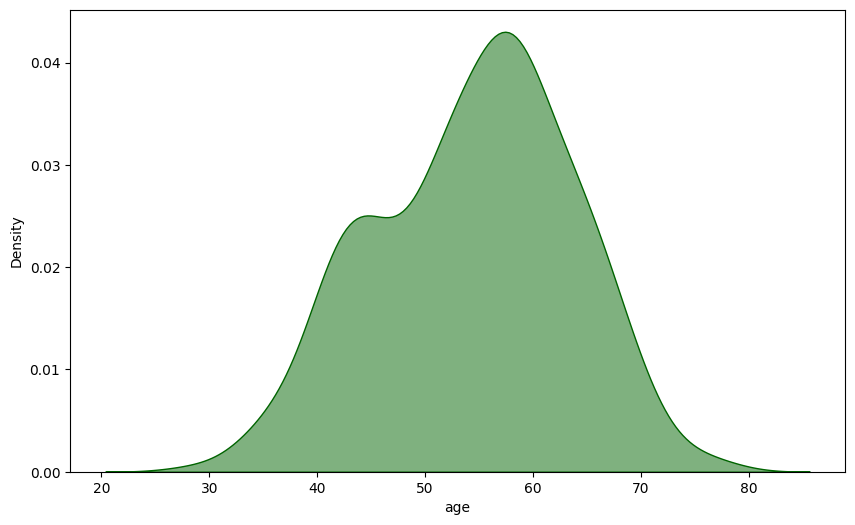

In [5]:
# Model Development Life Cycle 2 - Exploratory Data Analysis
# age distribution
plt.figure(figsize=(10, 6))
sns.kdeplot(df['age'], color='darkgreen', linewidth=1, fill=True, alpha=0.5)
plt.show()

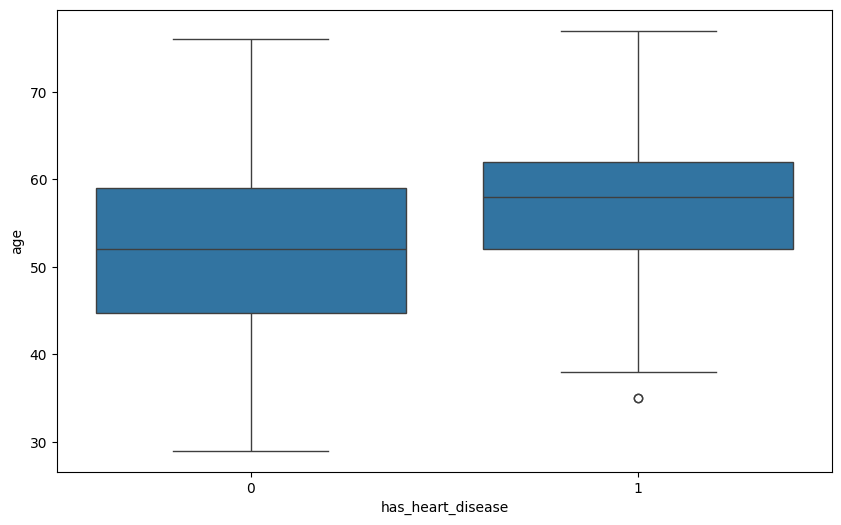

In [6]:
# boxplot to visually see if there is a significant difference in age on heart disease
plt.figure(figsize=(10, 6))
sns.boxplot(x='has_heart_disease', y='age', data=df)
plt.show()

In [7]:
# Is there a significant difference in mean age to have heart disease
f_statistic, p_value = stats.f_oneway(df[df['has_heart_disease'] < 1]['age'], df[df['has_heart_disease'] > 0]['age'])
print("F_statistic : {} | p_value: {}".format(f_statistic, p_value))

F_statistic : 15.769637007269537 | p_value: 8.955636917529726e-05


In [8]:
# From the above one way anova, there seems to be a significant difference in means in age for groups within has_heart_disease

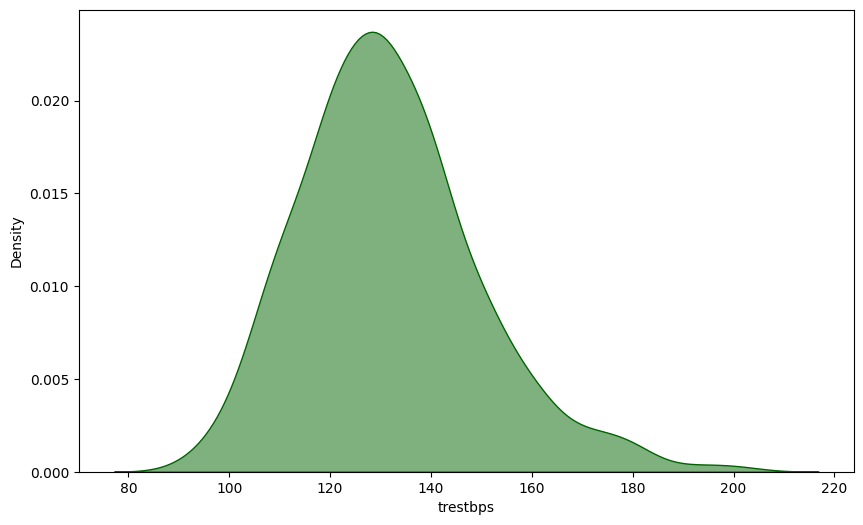

In [9]:
# trestbps distribution
plt.figure(figsize=(10, 6))
sns.kdeplot(df['trestbps'], color='darkgreen', linewidth=1, fill=True, alpha=0.5)
plt.show()

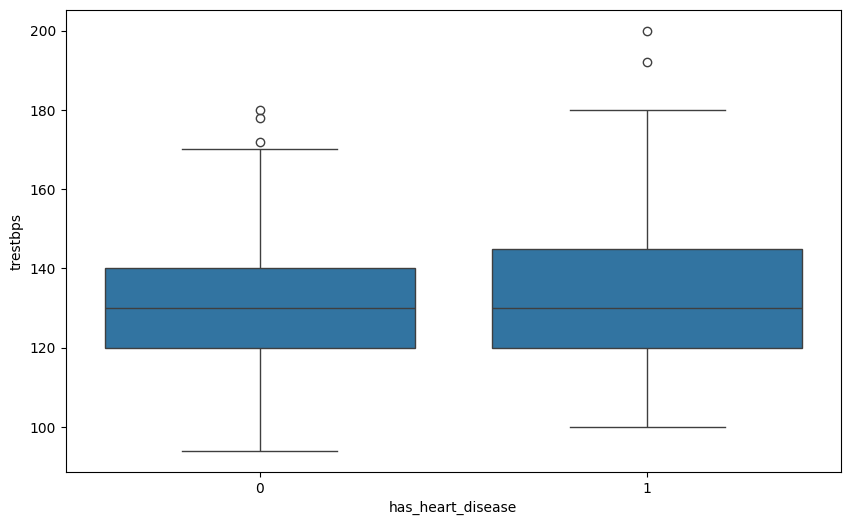

In [10]:
# boxplot to visually see if there is a significant difference in tresbps on heart disease
plt.figure(figsize=(10, 6))
sns.boxplot(x='has_heart_disease', y='trestbps', data=df)
plt.show()

In [11]:
# Is there a significant difference in mean tresbps to have heart disease
f_statistic, p_value = stats.f_oneway(df[df['has_heart_disease'] < 1]['trestbps'], df[df['has_heart_disease'] > 0]['trestbps'])
print("F_statistic : {} | p_value: {}".format(f_statistic, p_value))

F_statistic : 7.006632276706514 | p_value: 0.008548268928594905


In [12]:
# From the above one way anova, there seems not to be a significant difference in means in tresbps for groups within has_heart_disease

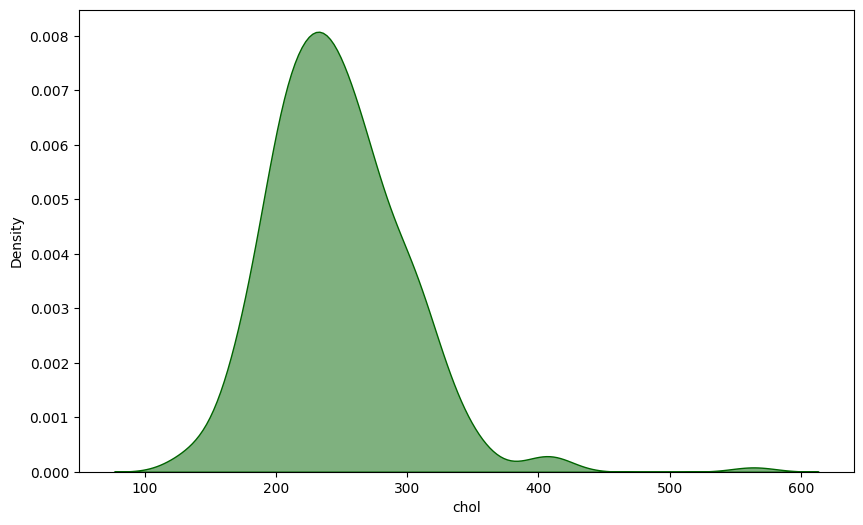

In [13]:
# chol distribution
plt.figure(figsize=(10, 6))
sns.kdeplot(df['chol'], color='darkgreen', linewidth=1, fill=True, alpha=0.5)
plt.show()

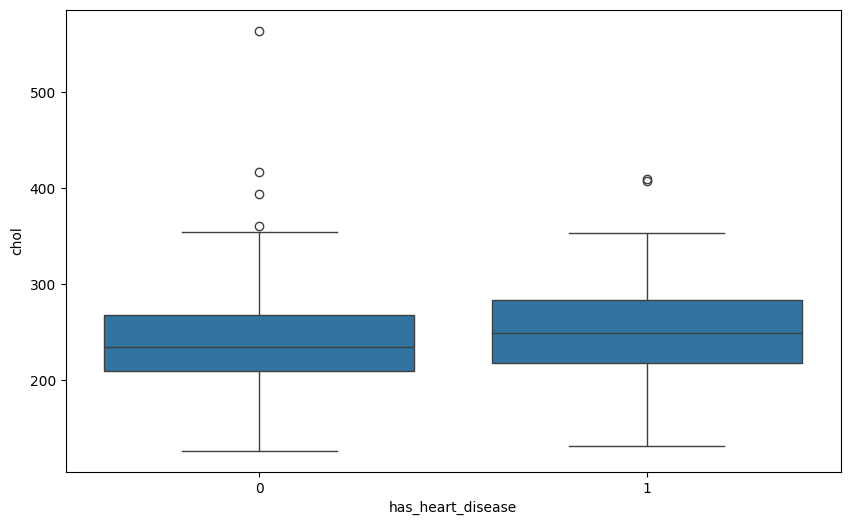

In [14]:
# boxplot to visually see if there is a significant difference in chol on heart disease
plt.figure(figsize=(10, 6))
sns.boxplot(x='has_heart_disease', y='chol', data=df)
plt.show()

In [15]:
# Is there a significant difference in mean chol to have heart disease
f_statistic, p_value = stats.f_oneway(df[df['has_heart_disease'] < 1]['trestbps'], df[df['has_heart_disease'] > 0]['trestbps'])
print("F_statistic : {} | p_value: {}".format(f_statistic, p_value))

F_statistic : 7.006632276706514 | p_value: 0.008548268928594905


In [16]:
# From the above one way anova, there seems not to be a significant difference in means in chol for groups within has_heart_disease

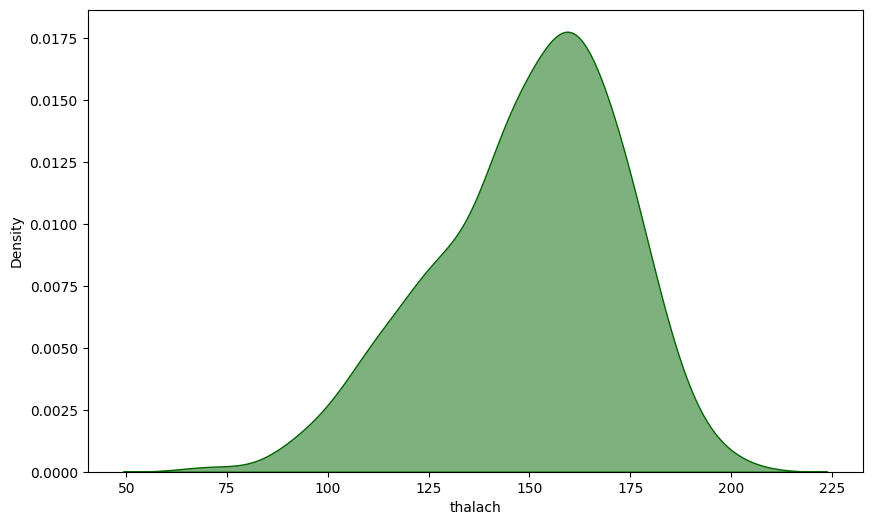

In [17]:
# thalach distribution
plt.figure(figsize=(10, 6))
sns.kdeplot(df['thalach'], color='darkgreen', linewidth=1, fill=True, alpha=0.5)
plt.show()

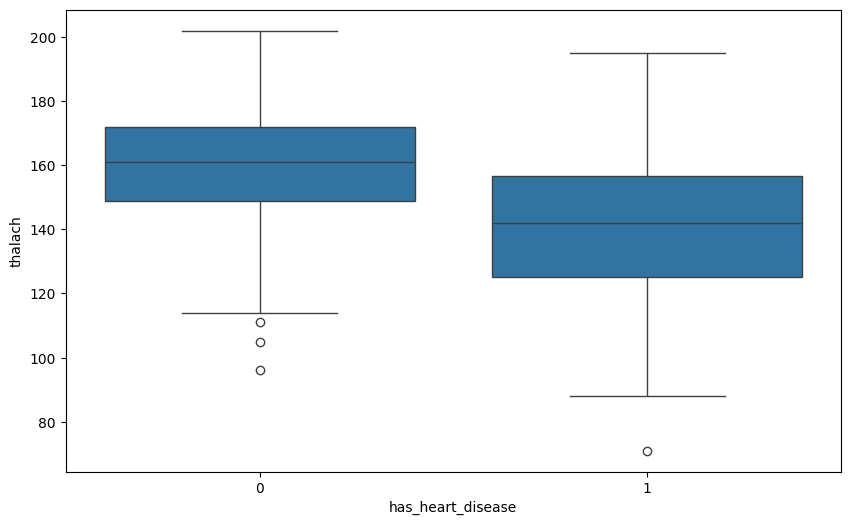

In [18]:
# boxplot to visually see if there is a significant difference in thalach on heart disease
plt.figure(figsize=(10, 6))
sns.boxplot(x='has_heart_disease', y='thalach', data=df)
plt.show()

In [19]:
# Is there a significant difference in mean thalach to have heart disease
f_statistic, p_value = stats.f_oneway(df[df['has_heart_disease'] < 1]['thalach'], df[df['has_heart_disease'] > 0]['thalach'])
print("F_statistic : {} | p_value: {}".format(f_statistic, p_value))

F_statistic : 63.41922251750833 | p_value: 3.4569649084303354e-14


In [20]:
# From the above one way anova, there seems to be a significant difference in means in thalach for groups within has_heart_disease

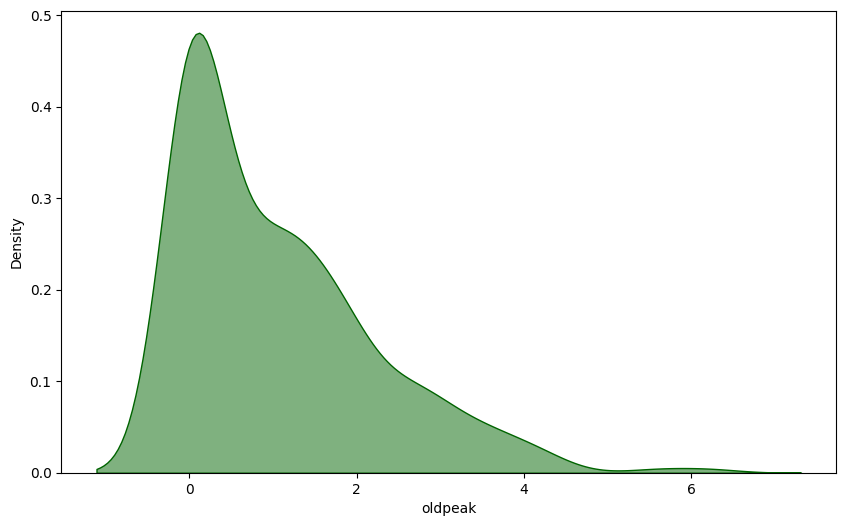

In [21]:
# oldpeak distribution
plt.figure(figsize=(10, 6))
sns.kdeplot(df['oldpeak'], color='darkgreen', linewidth=1, fill=True, alpha=0.5)
plt.show()

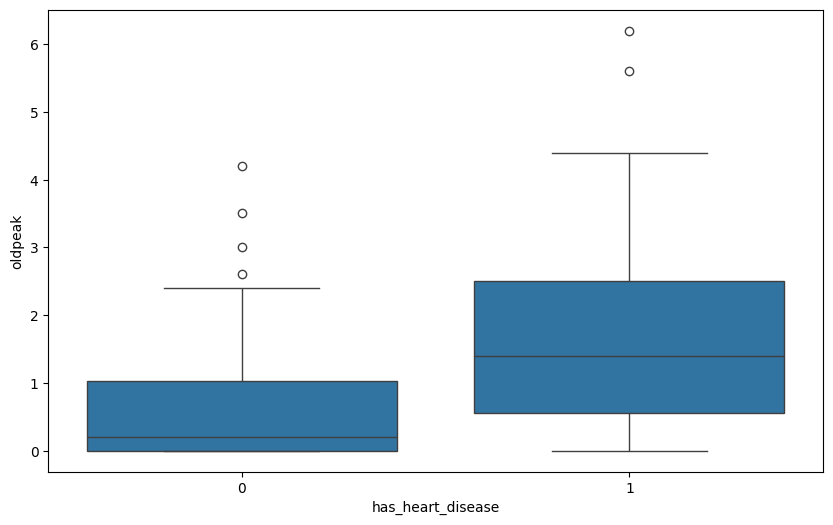

In [22]:
# boxplot to visually see if there is a significant difference in oldpeak on heart disease
plt.figure(figsize=(10, 6))
sns.boxplot(x='has_heart_disease', y='oldpeak', data=df)
plt.show()

In [23]:
# Is there a significant difference in mean thalach to have heart disease
f_statistic, p_value = stats.f_oneway(df[df['has_heart_disease'] < 1]['oldpeak'], df[df['has_heart_disease'] > 0]['oldpeak'])
print("F_statistic : {} | p_value: {}".format(f_statistic, p_value))

F_statistic : 66.16670679090824 | p_value: 1.097605339698471e-14


In [24]:
# association between categorical variables and heart disease
catg_cols = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'ca', 'thal']
catg_col_pval = []

for var in catg_cols:
    contingency_table_counts = pd.crosstab(df[var], df['has_heart_disease'])
    chi2, p_value, dof, expected = stats.chi2_contingency(contingency_table_counts)
    catg_col_pval.append(p_value)

data = {
    'Categorical Variables': catg_cols,
    'p value': catg_col_pval
}

pd.DataFrame(data)

,Categorical Variables,p value
0,sex,2.666712e-06
1,cp,1.251711e-17
2,fbs,7.812734e-01
3,restecg,6.566524e-03
4,exang,1.413788e-13
5,ca,6.350687e-15
6,thal,6.024778e-18


In [25]:
# From the above one way anova, there seems to be a significant difference in means in sex for groups within has_heart_disease
# From the above one way anova, there seems to be a significant difference in means in cp for groups within has_heart_disease
# From the above one way anova, there seems to be not a significant difference in means in fbs for groups within has_heart_disease
# From the above one way anova, there seems to be not a significant difference in means in restecg for groups within has_heart_disease
# From the above one way anova, there seems to be a significant difference in means in exang for groups within has_heart_disease
# From the above one way anova, there seems to be a significant difference in means in ca for groups within has_heart_disease
# From the above one way anova, there seems to be a significant difference in means in thal for groups within has_heart_disease

In [26]:
# Model Development Life Cycle 3 - Data Pre-Processing & Data Cleaning
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,num,has_heart_disease
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.438944,0.679868,3.158416,131.689769,246.693069,0.148515,0.990099,149.607261,0.326733,1.039604,1.600660,0.937294,0.458746
std,9.038662,0.467299,0.960126,17.599748,51.776918,0.356198,0.994971,22.875003,0.469794,1.161075,0.616226,1.228536,0.499120
min,29.000000,0.000000,1.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,48.000000,0.000000,3.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,56.000000,1.000000,3.000000,130.000000,241.000000,0.000000,1.000000,153.000000,0.000000,0.800000,2.000000,0.000000,0.000000
75%,61.000000,1.000000,4.000000,140.000000,275.000000,0.000000,2.000000,166.000000,1.000000,1.600000,2.000000,2.000000,1.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,4.000000,1.000000


In [27]:
# missing values
df = df.apply(pd.to_numeric, errors='coerce')
non_numeric_columns = df.isna().any()
non_numeric_columns

age                  False
sex                  False
cp                   False
trestbps             False
chol                 False
fbs                  False
restecg              False
thalach              False
exang                False
oldpeak              False
slope                False
ca                    True
thal                  True
num                  False
has_heart_disease    False
dtype: bool

In [28]:
df.dropna(inplace=True)
df
# we have treated missing values and there are very few outliers that aren't too far away from the range

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,has_heart_disease
0,63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,57,0,4,140,241,0,0,123,1,0.2,2,0.0,7.0,1,1
298,45,1,1,110,264,0,0,132,0,1.2,2,0.0,7.0,1,1
299,68,1,4,144,193,1,0,141,0,3.4,2,2.0,7.0,2,1
300,57,1,4,130,131,0,0,115,1,1.2,2,1.0,7.0,3,1


In [29]:
# we have slight imbalance but it is not over-imbalanced case
df['has_heart_disease'].value_counts()

has_heart_disease
0    160
1    137
Name: count, dtype: int64

In [30]:
# check for multicollinearity
X = df[['age', 'trestbps', 'chol', 'thalach', 'oldpeak']]
X_with_const = add_constant(X)
vif_data = pd.DataFrame()
vif_data["feature"] = X_with_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_with_const.values, i) 
                   for i in range(X_with_const.shape[1])]
vif_data

,feature,VIF
0,const,167.917479
1,age,1.347358
2,trestbps,1.137604
3,chol,1.056714
4,thalach,1.330874
5,oldpeak,1.178751


In [31]:
# considering the rule of thumb, the VIF values are less than 5 so we can say that our dataset is not suffering from multicollinearity

In [32]:
# since we are resorting to using ensemble methods and the categorical variables are already label encoded, we are good to go for train test split
X = df[['age','sex','cp','trestbps','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal']]
y = df['has_heart_disease']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [33]:
full_pipeline = Pipeline(steps=[
    ('classifier', RandomForestClassifier(random_state=42))
])

param_dist = {
    'classifier__n_estimators': [80, 100, 200, 500], 
    'classifier__max_depth': [10, 20, 30, None], 
    'classifier__min_samples_split': [2, 5, 10], 
    'classifier__min_samples_leaf': [1, 2, 4], 
    'classifier__bootstrap': [True, False]
}

random_search = RandomizedSearchCV(
    estimator=full_pipeline,
    param_distributions=param_dist,
    n_iter=10,        
    cv=5,             
    verbose=2,
    random_state=42,
    n_jobs=-1         
)

random_search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


,estimator,Pipeline(step...m_state=42))])
,param_distributions,"{'classifier__bootstrap': [True, False], 'classifier__max_depth': [10, 20, ...], 'classifier__min_samples_leaf': [1, 2, ...], 'classifier__min_samples_split': [2, 5, ...], ...}"
,n_iter,10
,scoring,None
,n_jobs,-1
,refit,True
,cv,5
,verbose,2
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [34]:
print("--- Results ---")
print(f"Best parameters found: {random_search.best_params_}")
print(f"Best cross-validation score (accuracy): {random_search.best_score_:.4f}")

--- Results ---
Best parameters found: {'classifier__n_estimators': 100, 'classifier__min_samples_split': 2, 'classifier__min_samples_leaf': 2, 'classifier__max_depth': 10, 'classifier__bootstrap': False}
Best cross-validation score (accuracy): 0.8311


In [36]:
print("--- Best Model ---")
best_model = random_search.best_estimator_
test_score = best_model.score(X_test, y_test)
print(f"Test set score (accuracy): {test_score:.4f}")

--- Best Model ---
Test set score (accuracy): 0.8444


In [37]:
forest = RandomForestClassifier(random_state=42,
                                n_estimators=100,
                                min_samples_split=2,
                                min_samples_leaf=2,
                                max_depth=10,
                                bootstrap=False).fit(X_train, y_train)
importances = forest.feature_importances_
feature_names = X_train.columns.tolist()
forest_importances = pd.Series(importances, index=feature_names)
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

In [38]:
forest_importances

age         0.081975
sex         0.024975
cp          0.165651
trestbps    0.074270
chol        0.070977
fbs         0.004959
restecg     0.024531
thalach     0.091373
exang       0.062386
oldpeak     0.102700
slope       0.041310
ca          0.115715
thal        0.139178
dtype: float64

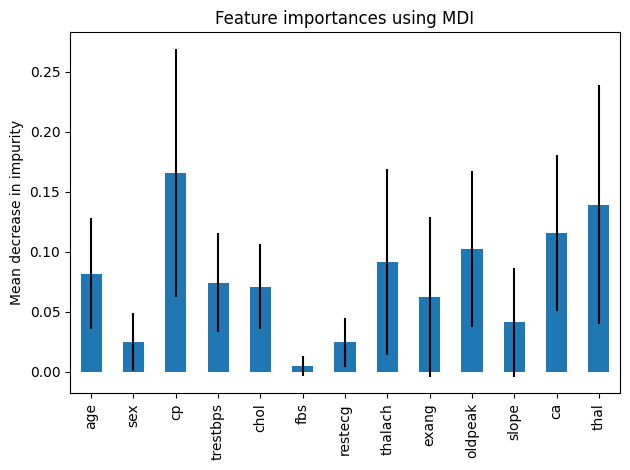

In [39]:
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [40]:
# we see important features that lead to decrease in impurity for fitted trees 
# some of the less important variables are sex, fbs (fasting blood sugar) and restecg
# some of the important ones are cp, thal, ca, oldpeak, thalach

In [41]:
full_pipeline = Pipeline(steps=[
    ('xgb', XGBClassifier(
        objective='binary:logistic',
        eval_metric='mlogloss', 
        use_label_encoder=False, 
        random_state=42, 
        n_jobs=-1,
        n_estimators=100 
    ))
])

param_dist = {
    'xgb__n_estimators': randint(100, 1000), 
    'xgb__max_depth': randint(3, 10),
    'xgb__learning_rate': uniform(0.01, 0.2), 
    'xgb__reg_alpha': uniform(0.0, 1.0),
    'xgb__reg_lambda': uniform(0.0, 1.0),
    'xgb__subsample': uniform(0.6, 0.4),
    'xgb__colsample_bytree': uniform(0.6, 0.4),
    'xgb__gamma': uniform(0, 0.5),
}

random_search = RandomizedSearchCV(
    estimator=full_pipeline,
    param_distributions=param_dist,
    n_iter=50,        
    cv=5,             
    scoring='accuracy', 
    verbose=1,
    random_state=42,
    n_jobs=-1          
)

random_search.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


C:\Users\patel\miniconda3\envs\midas_env\Lib\site-packages\xgboost\training.py:199: UserWarning: [15:54:08] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,estimator,"Pipeline(step...=None, ...))])"
,param_distributions,"{'xgb__colsample_bytree': <scipy.stats....0017DF62BAE10>, 'xgb__gamma': <scipy.stats....0017DF62B8B60>, 'xgb__learning_rate': <scipy.stats....0017DF647B020>, 'xgb__max_depth': <scipy.stats....0017DF502E8D0>, ...}"
,n_iter,50
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,5
,verbose,1
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [42]:
print("\n--- Randomized Search Results ---")
print(f"Best parameters found (Best Estimator): \n{random_search.best_params_}")
print(f"\nBest cross-validation score (Accuracy): {random_search.best_score_:.4f}")


--- Randomized Search Results ---
Best parameters found (Best Estimator): 
{'xgb__colsample_bytree': np.float64(0.9812287388095813), 'xgb__gamma': np.float64(0.16537515233525685), 'xgb__learning_rate': np.float64(0.12055299336709799), 'xgb__max_depth': 9, 'xgb__n_estimators': 198, 'xgb__reg_alpha': np.float64(0.9803315837160457), 'xgb__reg_lambda': np.float64(0.07534625600612821), 'xgb__subsample': np.float64(0.7222788077148727)}

Best cross-validation score (Accuracy): 0.8264


In [43]:
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
test_score = best_model.score(X_test, y_test)
print(f"Test set score (Accuracy): {test_score:.4f}")

Test set score (Accuracy): 0.8778


In [44]:
feature_names_out = X_train.columns.tolist()
importance = best_model['xgb'].feature_importances_
importance_df = pd.Series(importance, index=feature_names_out).sort_values(ascending=False)

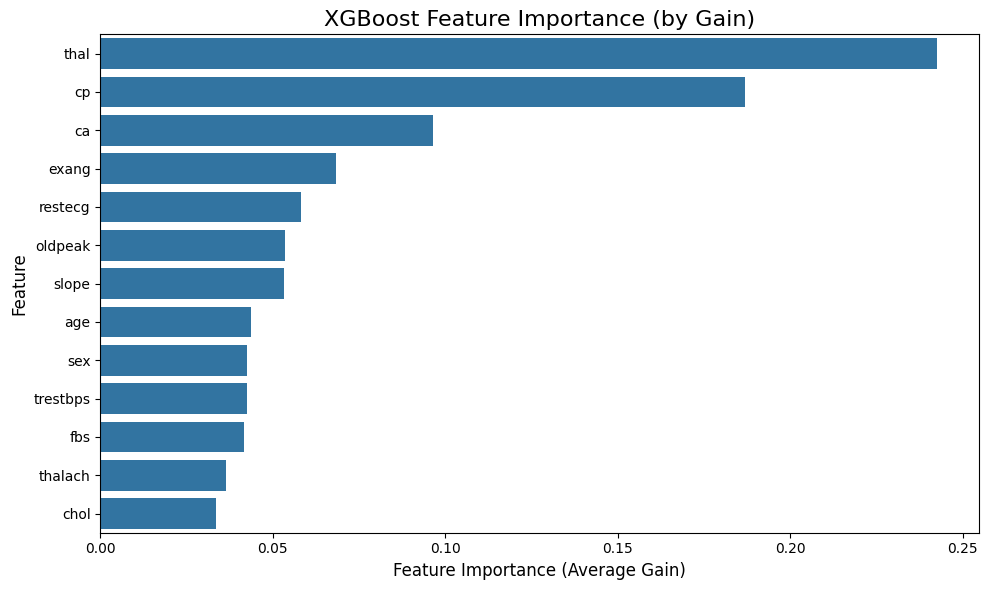

In [45]:
plt.figure(figsize=(10, 6)) 
sns.barplot(x=importance_df.values, y=importance_df.index)
plt.title('XGBoost Feature Importance (by Gain)', fontsize=16)
plt.xlabel('Feature Importance (Average Gain)', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout() 
plt.show()

In [46]:
# comparing the important features suggested by Random forest model, we see top important fields conforming with XgBoost - thal, cp, ca
# however there is some non conformity with variables like chol, thalach, oldpeak

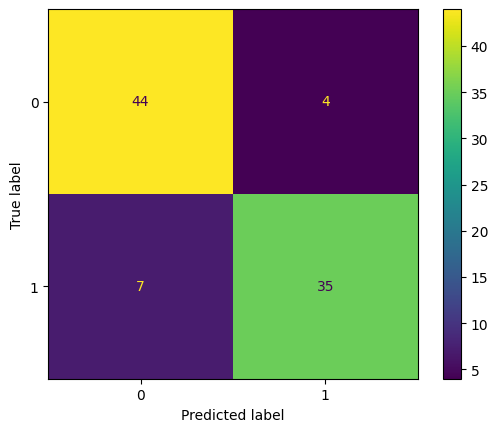

In [54]:
confusion_plot = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, y_pred), display_labels = [0, 1])
confusion_plot.plot()

In [55]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.92      0.89        48
           1       0.90      0.83      0.86        42

    accuracy                           0.88        90
   macro avg       0.88      0.88      0.88        90
weighted avg       0.88      0.88      0.88        90



In [58]:
# we shall choose the Xgboost model for deployment!!!
filename = 'heart_xgboost_model_v1.joblib'
joblib.dump(best_model, filename)

['heart_xgboost_model_v1.joblib']